# E-Flux2 (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import pandas as pd
import sys


source_dir = '../src'
sys.path.append(source_dir)

from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary

from get_pfba_gsm_df import get_pfba_gsm_df
from get_eflux2_gsm_df import get_eflux2_gsm_df
from get_pfba_biomass_flux import get_pfba_biomass_flux
from get_eflux2_biomass_fluxes import get_eflux2_biomass_fluxes
from get_eflux2_fva_fluxes import get_eflux2_fva_fluxes

from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from add_transcript_values_to_13c_flux_df import add_transcript_values_to_13c_flux_df

from make_4_boxplot_grid import make_4_boxplot_grid


### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_2.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id  = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x134cf5a20
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load transcriptomics data

In [4]:
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [5]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [6]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Load 13C-MFA and pFBA data

In [7]:
# load glucose 13C MFA data from ../data/13c_mfa/INCA_model_08302023_GR.xlsx
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_08302023_GR.xlsx', sheet_name='GSM Format')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0000,2.201100e-11,100.0000,100.0000,0.0000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-12.29,5.856500e+00,-23.5032,-2.2969,21.2063,-151.6655,1.094870e+01,-165.8804,-1.3939,164.4865


# Glucose

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [8]:
glucose_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glucose'
)
print(f'glucose max pfba biomass flux: {glucose_pfba_biomass_flux} g biomass per 100 mmols glucose')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glucose minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glucose')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'glucose FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glucose')

glucose max pfba biomass flux: 11.398166174414 g biomass per 100 mmols glucose
glucose minimum eflux2 biomass flux: 10.221715466034821 g biomass per 100 mmols glucose
glucose FVA biomass cutoff flux: 10.119498311374473 g biomass per 100 mmols glucose


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [9]:
glucose_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glucose_gsm_df.to_csv('../results/gsm_fluxes/glucose_gsm_fluxes.csv', index=False)

glucose_gsm_df.head()

Running pFBA FVA with the constraints: EX_glc_e = -100, biomass_C >= 10.119498311374473:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -8.364070958882, biomass_C >= 0.8464020194462266:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -5.081335085181, biomass_C >= 0.51420561814017:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -5.136872535908, biomass_C >= 0.5198257295286691:


,reaction_id,reaction_name,full_reaction,glucose_pfba_flux,glucose_pfba_LB,glucose_pfba_UB,glucose_1_eflux2_flux,glucose_1_trans_LB,glucose_1_trans_UB,glucose_1_eflux2_LB,...,glucose_2_eflux2_flux,glucose_2_trans_LB,glucose_2_trans_UB,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_3_eflux2_flux,glucose_3_trans_LB,glucose_3_trans_UB,glucose_3_eflux2_LB,glucose_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-560.394053,-1000.000000,-353.659697,-666.959559,-inf,inf,-3375.373353,...,-667.557678,-inf,inf,-5011.067224,-573.866508,-667.221169,-inf,inf,-4734.613006,-563.827547
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],341.609652,257.108133,536.797238,365.261313,0.000000e+00,5.079715e+04,319.691748,...,365.378556,0.000000e+00,7.895169e+04,324.131852,487.345963,365.312594,0.000000e+00,8.018186e+04,316.494671,488.859341
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],335.476108,-158.248170,885.829756,365.261313,-3.848604e+02,3.848604e+02,62.788242,...,365.378556,-7.496061e+02,7.496061e+02,80.916855,749.606144,365.312594,-6.801804e+02,6.801804e+02,70.288612,680.180397
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,326.533474,235.764410,528.318155,366.566172,0.000000e+00,1.253457e+03,322.781317,...,366.662025,0.000000e+00,2.388742e+03,329.580622,490.241446,366.608097,0.000000e+00,2.258183e+03,325.428506,492.408829
421,EX_h2o_e,H2O exchange,h2o[e] <=>,325.265198,277.527573,411.487796,320.522192,-1.195590e+05,1.195590e+04,309.081823,...,316.963941,-1.967987e+05,1.967987e+04,312.002291,380.529035,318.965861,-1.946710e+05,1.946710e+04,310.288780,380.704473


### Create a glucose central reaction dataframe from genome-scale predictions

In [10]:
glucose_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_flux')
glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_LB', 'glucose_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glucose_1', 'glucose_2', 'glucose_3']:
    # add glucose eflux2 data for the specific trial
    glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_flux')
    glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glucose_central_rxn_df = add_transcript_values_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glucose_gsm_df.to_csv('../results/central_fluxes/glucose_central_fluxes.csv', index=False)

glucose_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_2_eflux2_flux,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_2_trans_LB,glucose_2_trans_UB,glucose_3_eflux2_flux,glucose_3_eflux2_LB,glucose_3_eflux2_UB,glucose_3_trans_LB,glucose_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,100.0,100.0,100.0,-19679.867264,19679.867264,100.0,100.0,100.0,-19467.097792,19467.097792
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,-9.164436,-10.955119,0.0,-39730.10963,39730.10963,-8.086446,-11.319083,0.0,-54030.73525,54030.73525
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-44.923378,-89.091363,-27.675304,-15394.576167,15394.576167,-44.148332,-108.201022,-22.762353,-14997.257468,14997.257468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glucose MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

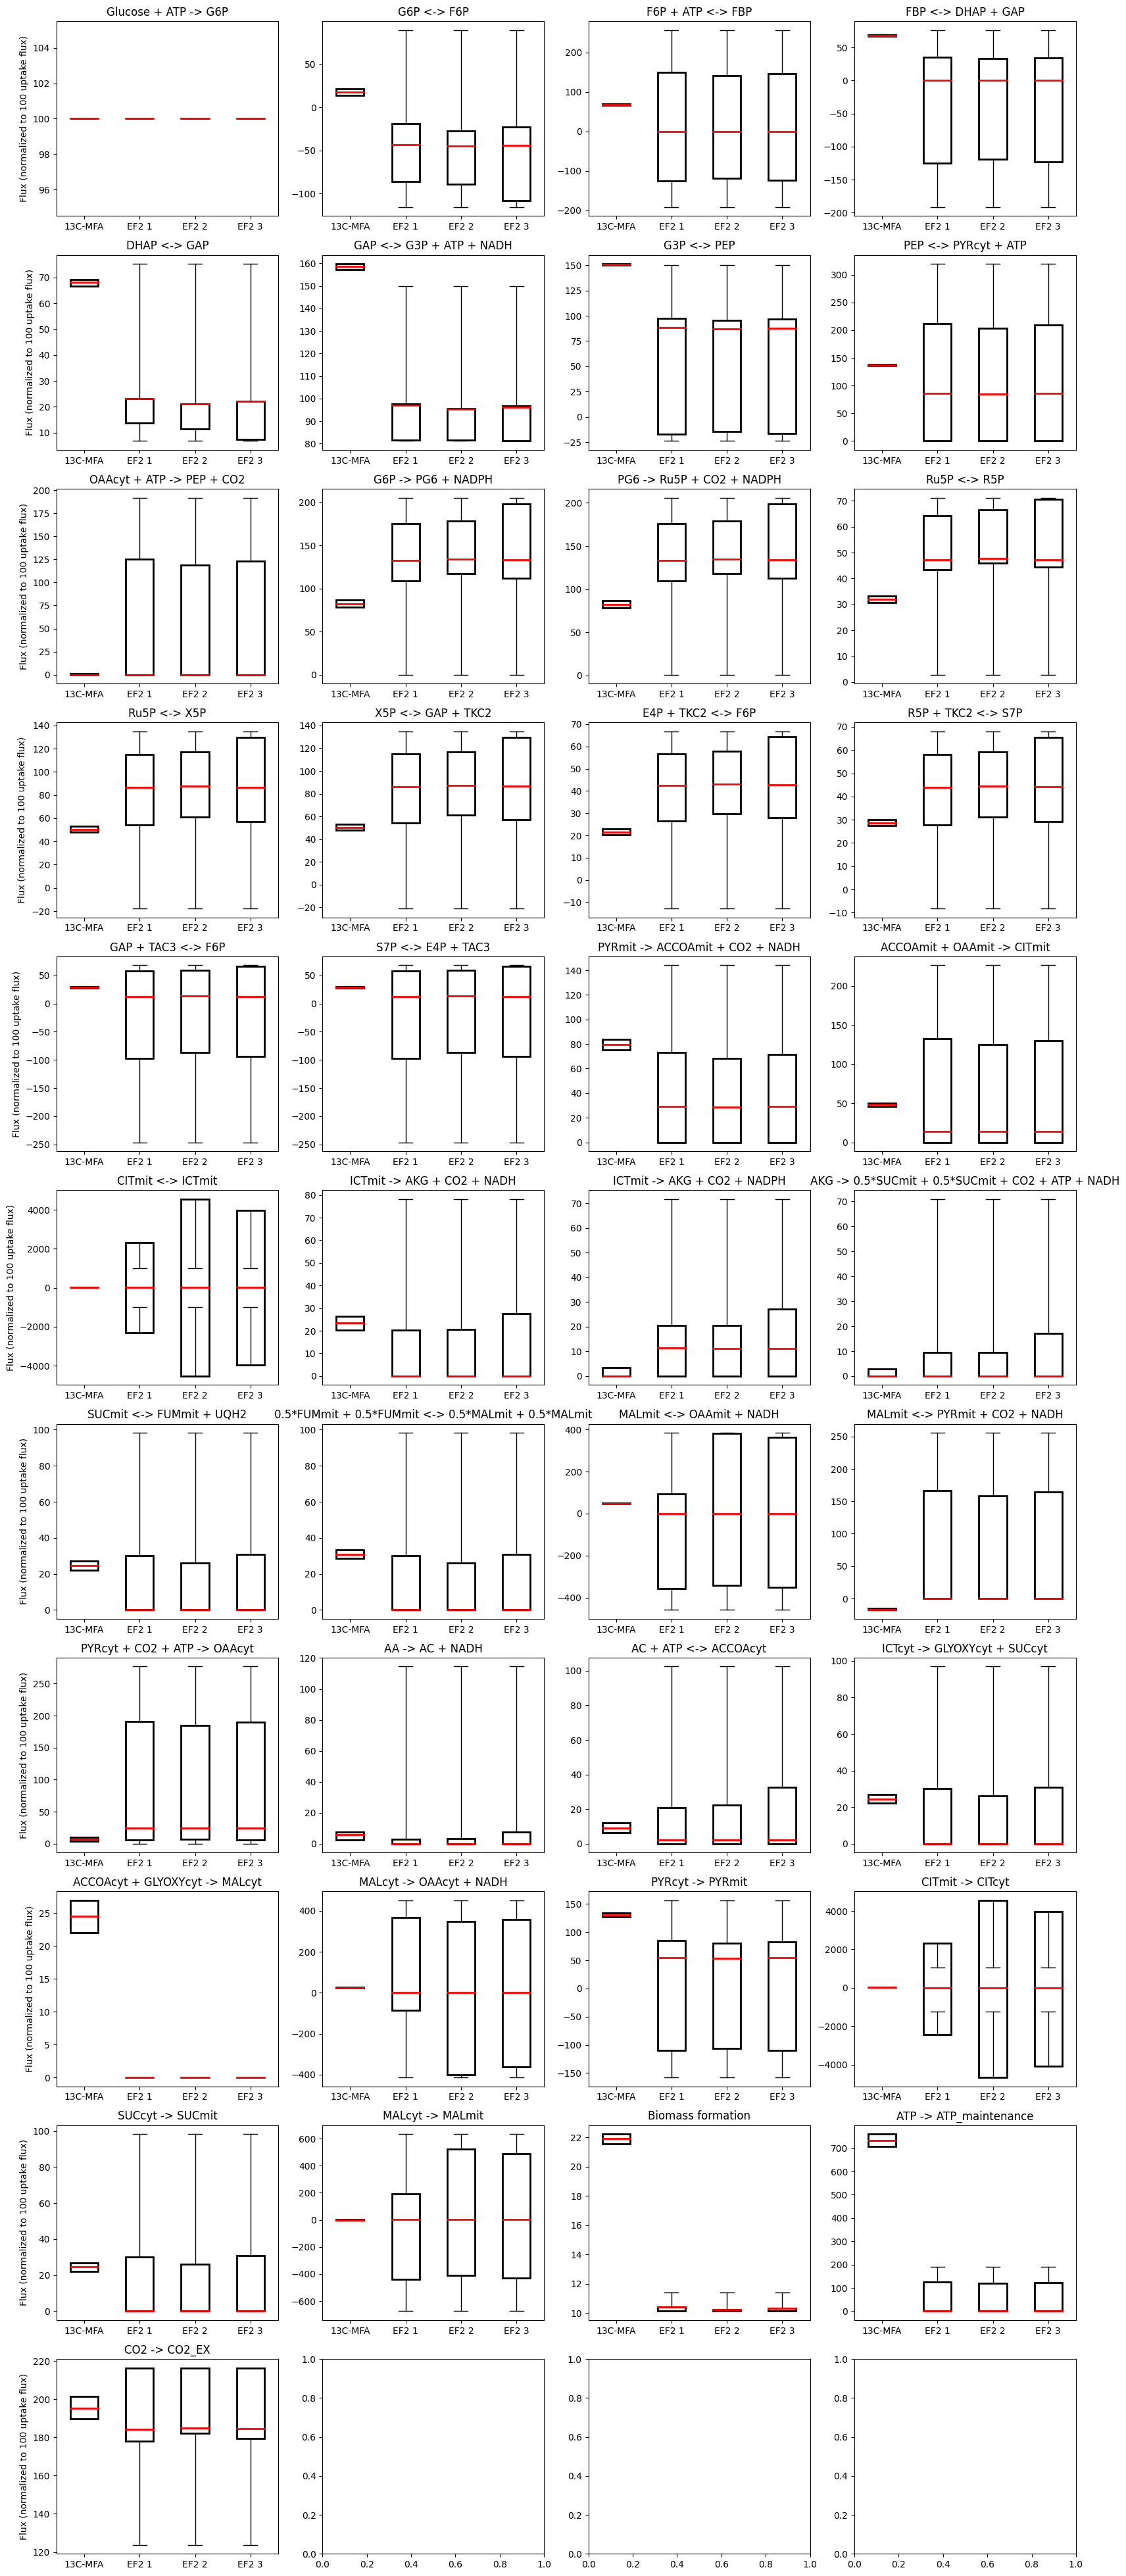

In [11]:
make_4_boxplot_grid(glucose_central_rxn_df, 'glucose')

# Glycerol

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [12]:
glycerol_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glycerol'
)
print(f'glycerol max pfba biomass flux: {glycerol_pfba_biomass_flux} g biomass per 100 mmols glycerol')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glycerol minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glycerol')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'glycerol FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glycerol')

glycerol max pfba biomass flux: 4.66984653044 g biomass per 100 mmols glycerol
glycerol minimum eflux2 biomass flux: 2.199939160662268 g biomass per 100 mmols glycerol
glycerol FVA biomass cutoff flux: 2.1779397690556452 g biomass per 100 mmols glycerol


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [13]:
glycerol_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glycerol_gsm_df.to_csv('../results/gsm_fluxes/glycerol_gsm_fluxes.csv', index=False)

glycerol_gsm_df.head()

Running pFBA FVA with the constraints: EX_glyc_e = -100, biomass_C >= 2.1779397690556452:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -18.791414798787, biomass_C >= 0.4092656960709899:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -17.734276485515, biomass_C >= 0.38624186033231495:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -9.440184697661, biomass_C >= 0.20560153680266435:


,reaction_id,reaction_name,full_reaction,glycerol_pfba_flux,glycerol_pfba_LB,glycerol_pfba_UB,glycerol_1_eflux2_flux,glycerol_1_trans_LB,glycerol_1_trans_UB,glycerol_1_eflux2_LB,...,glycerol_2_eflux2_flux,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_3_eflux2_flux,glycerol_3_trans_LB,glycerol_3_trans_UB,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-574.850423,-1000.000000,-182.393410,-432.478309,-inf,inf,-1556.596363,...,-430.698245,-inf,inf,-1589.380589,-417.055878,-413.138609,-inf,inf,-2705.288152,-280.954520
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-354.104943,-529.137638,-206.154617,-220.541970,-inf,inf,-235.357113,...,-221.317091,-inf,inf,-235.357113,-217.451252,-251.645205,-inf,inf,-320.426870,-206.314574
421,EX_h2o_e,H2O exchange,h2o[e] <=>,354.104943,206.154617,529.137638,220.541970,-5.321579e+04,5321.579087,218.228385,...,221.317091,-5.638798e+04,5638.797843,217.451252,235.357113,251.645205,-1.059301e+05,1.059301e+04,206.314574,320.426870
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],315.462030,-154.906224,989.465145,226.995975,-2.811390e+02,281.139023,108.139511,...,222.293524,-3.190996e+02,319.099570,76.747427,319.099570,212.140168,-5.849462e+02,5.849462e+02,-44.370134,562.252154
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,313.155793,118.722997,637.762409,249.927329,0.000000e+00,742.998872,246.581214,...,252.569690,0.000000e+00,890.253404,246.568288,276.098231,245.228070,0.000000e+00,1.465649e+03,172.817922,352.904511


### Create a glycerol central reaction dataframe from genome-scale predictions

In [14]:
glycerol_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_flux')
glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_LB', 'glycerol_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glycerol_1', 'glycerol_2', 'glycerol_3']:
    # add glycerol eflux2 data for the specific trial
    glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_flux')
    glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glycerol_central_rxn_df = add_transcript_values_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glycerol_gsm_df.to_csv('../results/central_fluxes/glycerol_central_fluxes.csv', index=False)

glycerol_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_2_eflux2_flux,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_3_eflux2_flux,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB,glycerol_3_trans_LB,glycerol_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,0.0,0.0,0.0,-5638.797843,0.0,0.0,0.0,0.0,-10593.013082,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,-12691.298694,12691.298694,100.0,100.0,100.0,-28475.184396,28475.184396
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-2.295899,-11.379836,-2.261023,-5025.860518,5025.860518,-2.797663,-44.325956,-2.261023,-8728.324989,8728.324989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glycerol MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

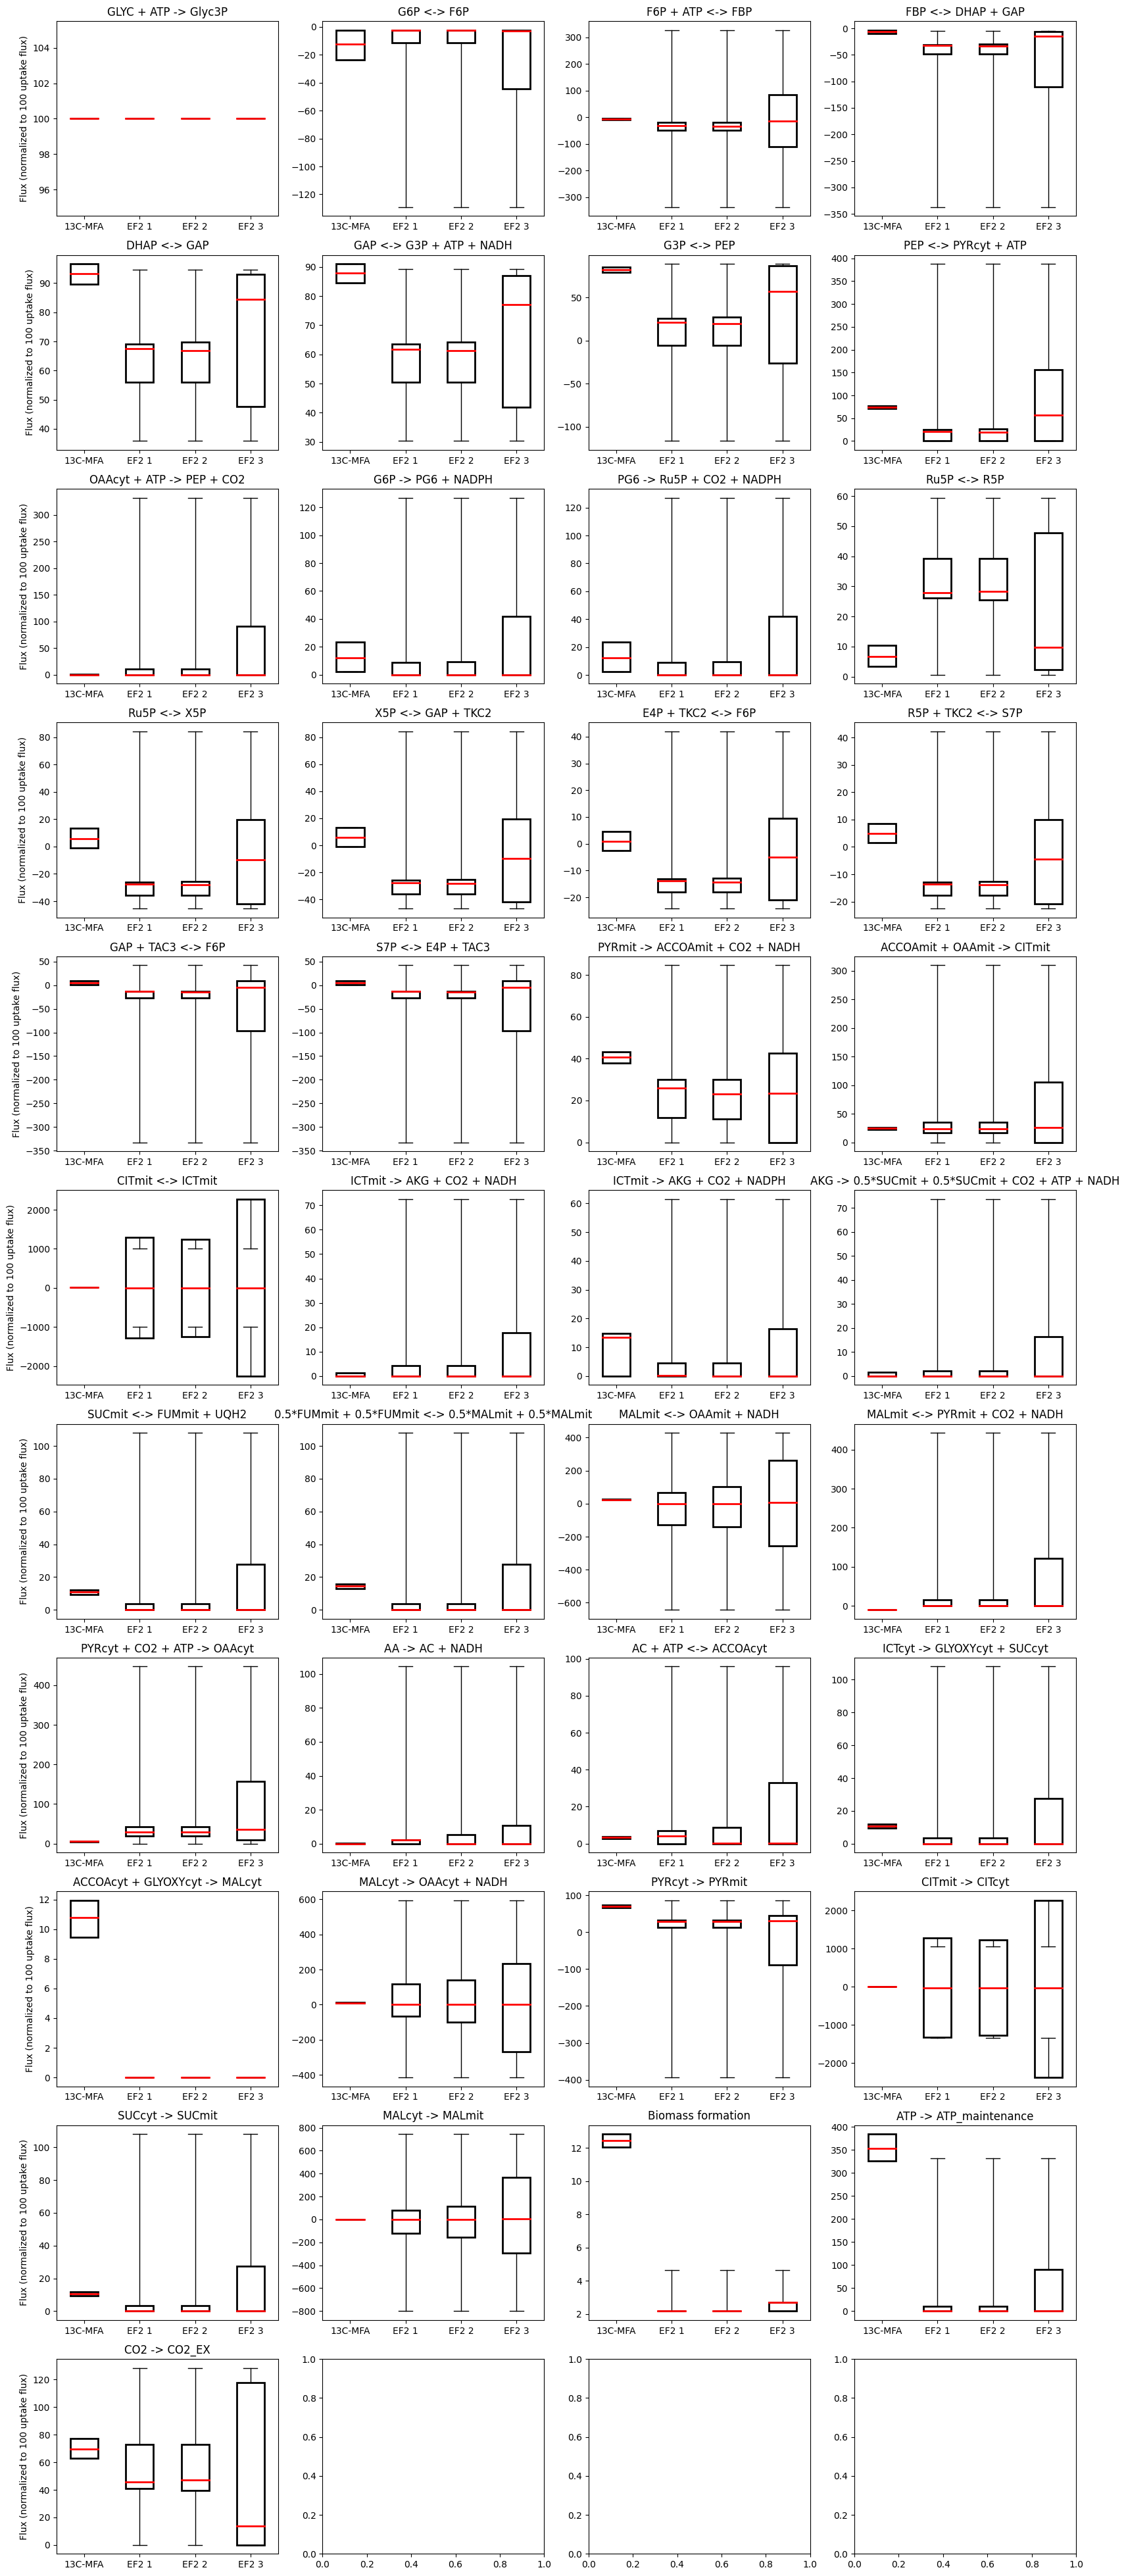

In [15]:
make_4_boxplot_grid(glycerol_central_rxn_df, 'glycerol')

# Oleic Acid

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [16]:
oleic_acid_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='oleic_acid'
)
print(f'oleic acid max pfba biomass flux: {oleic_acid_pfba_biomass_flux} g biomass per 100 mmols oleic acid')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'oleic acid minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols oleic acid')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'oleic acid FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols oleic acid')

oleic acid max pfba biomass flux: 29.57316982462 g biomass per 100 mmols oleic acid
oleic acid minimum eflux2 biomass flux: 28.984057229382575 g biomass per 100 mmols oleic acid
oleic acid FVA biomass cutoff flux: 28.69421665708875 g biomass per 100 mmols oleic acid


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [17]:
oleic_acid_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
oleic_acid_gsm_df.to_csv('../results/gsm_fluxes/oleic_acid_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df.head()

Running pFBA FVA with the constraints: EX_ocdcea_e = -10, biomass_C >= 2.869421665708875:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -2.26745174683, biomass_C >= 0.6506275168303436:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -0.987438663942, biomass_C >= 0.28333778958737993:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -1.426300292361, biomass_C >= 0.4092656960707556:


,reaction_id,reaction_name,full_reaction,oleic_acid_pfba_flux,oleic_acid_pfba_LB,oleic_acid_pfba_UB,oleic_acid_1_eflux2_flux,oleic_acid_1_trans_LB,oleic_acid_1_trans_UB,oleic_acid_1_eflux2_LB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3584.266821,-10000.000000,-2962.861872,-3041.050412,-inf,inf,-9152.638029,...,-3041.050412,-inf,inf,-17307.591266,-2962.861872,-3041.050412,-inf,inf,-12996.826922,-2962.861872
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2269.151708,2157.127605,2404.272228,2194.068288,0.00000,5.314336e+03,2157.127605,...,2194.068288,0.000000e+00,1.128374e+04,2157.127605,2404.272228,2194.068288,0.00000,7.155576e+03,2157.127605,2404.272228
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2265.438412,801.804062,3347.961195,2190.428963,-11642.14411,1.164214e+04,801.804062,...,2190.428963,-2.034759e+04,2.034759e+04,801.804062,3347.961194,2190.428963,-17743.10791,1.774311e+04,801.804062,3347.961194
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2265.438412,2152.151271,2544.372988,2190.428963,0.00000,1.203426e+05,2152.151271,...,2190.428963,0.000000e+00,4.035248e+05,2152.151271,2544.372988,2190.428963,0.00000,2.320297e+05,2152.151271,2544.372988
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,2053.128358,1958.422561,2122.880812,2099.879235,0.00000,6.117440e+03,1958.422561,...,2099.879235,0.000000e+00,1.909688e+04,1958.422561,2122.880812,2099.879235,0.00000,7.689124e+03,1958.422561,2122.880812


### Create a glycerol central reaction dataframe from genome-scale predictions

In [18]:
oleic_acid_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_flux')
oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_LB', 'oleic_acid_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['oleic_acid_1', 'oleic_acid_2', 'oleic_acid_3']:
    # add oleic_acid eflux2 data for the specific trial
    oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_flux')
    oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    oleic_acid_central_rxn_df = add_transcript_values_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
oleic_acid_gsm_df.to_csv('../results/central_fluxes/oleic_acid_central_fluxes.csv', index=False)

oleic_acid_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,0.0,0.0,0.0,-101272.113045,0.0,0.0,0.0,0.0,-70111.462877,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-10.06885,0.0,-447423.233597,447423.233597,0.0,-10.06885,0.0,-257292.242009,257292.242009
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,0.0,inf,100.0,100.0,100.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-30.089725,-251.806968,-29.788828,-83927.238244,83927.238244,-30.089725,-251.806968,-29.788828,-56267.954532,56267.954532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glycerol MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

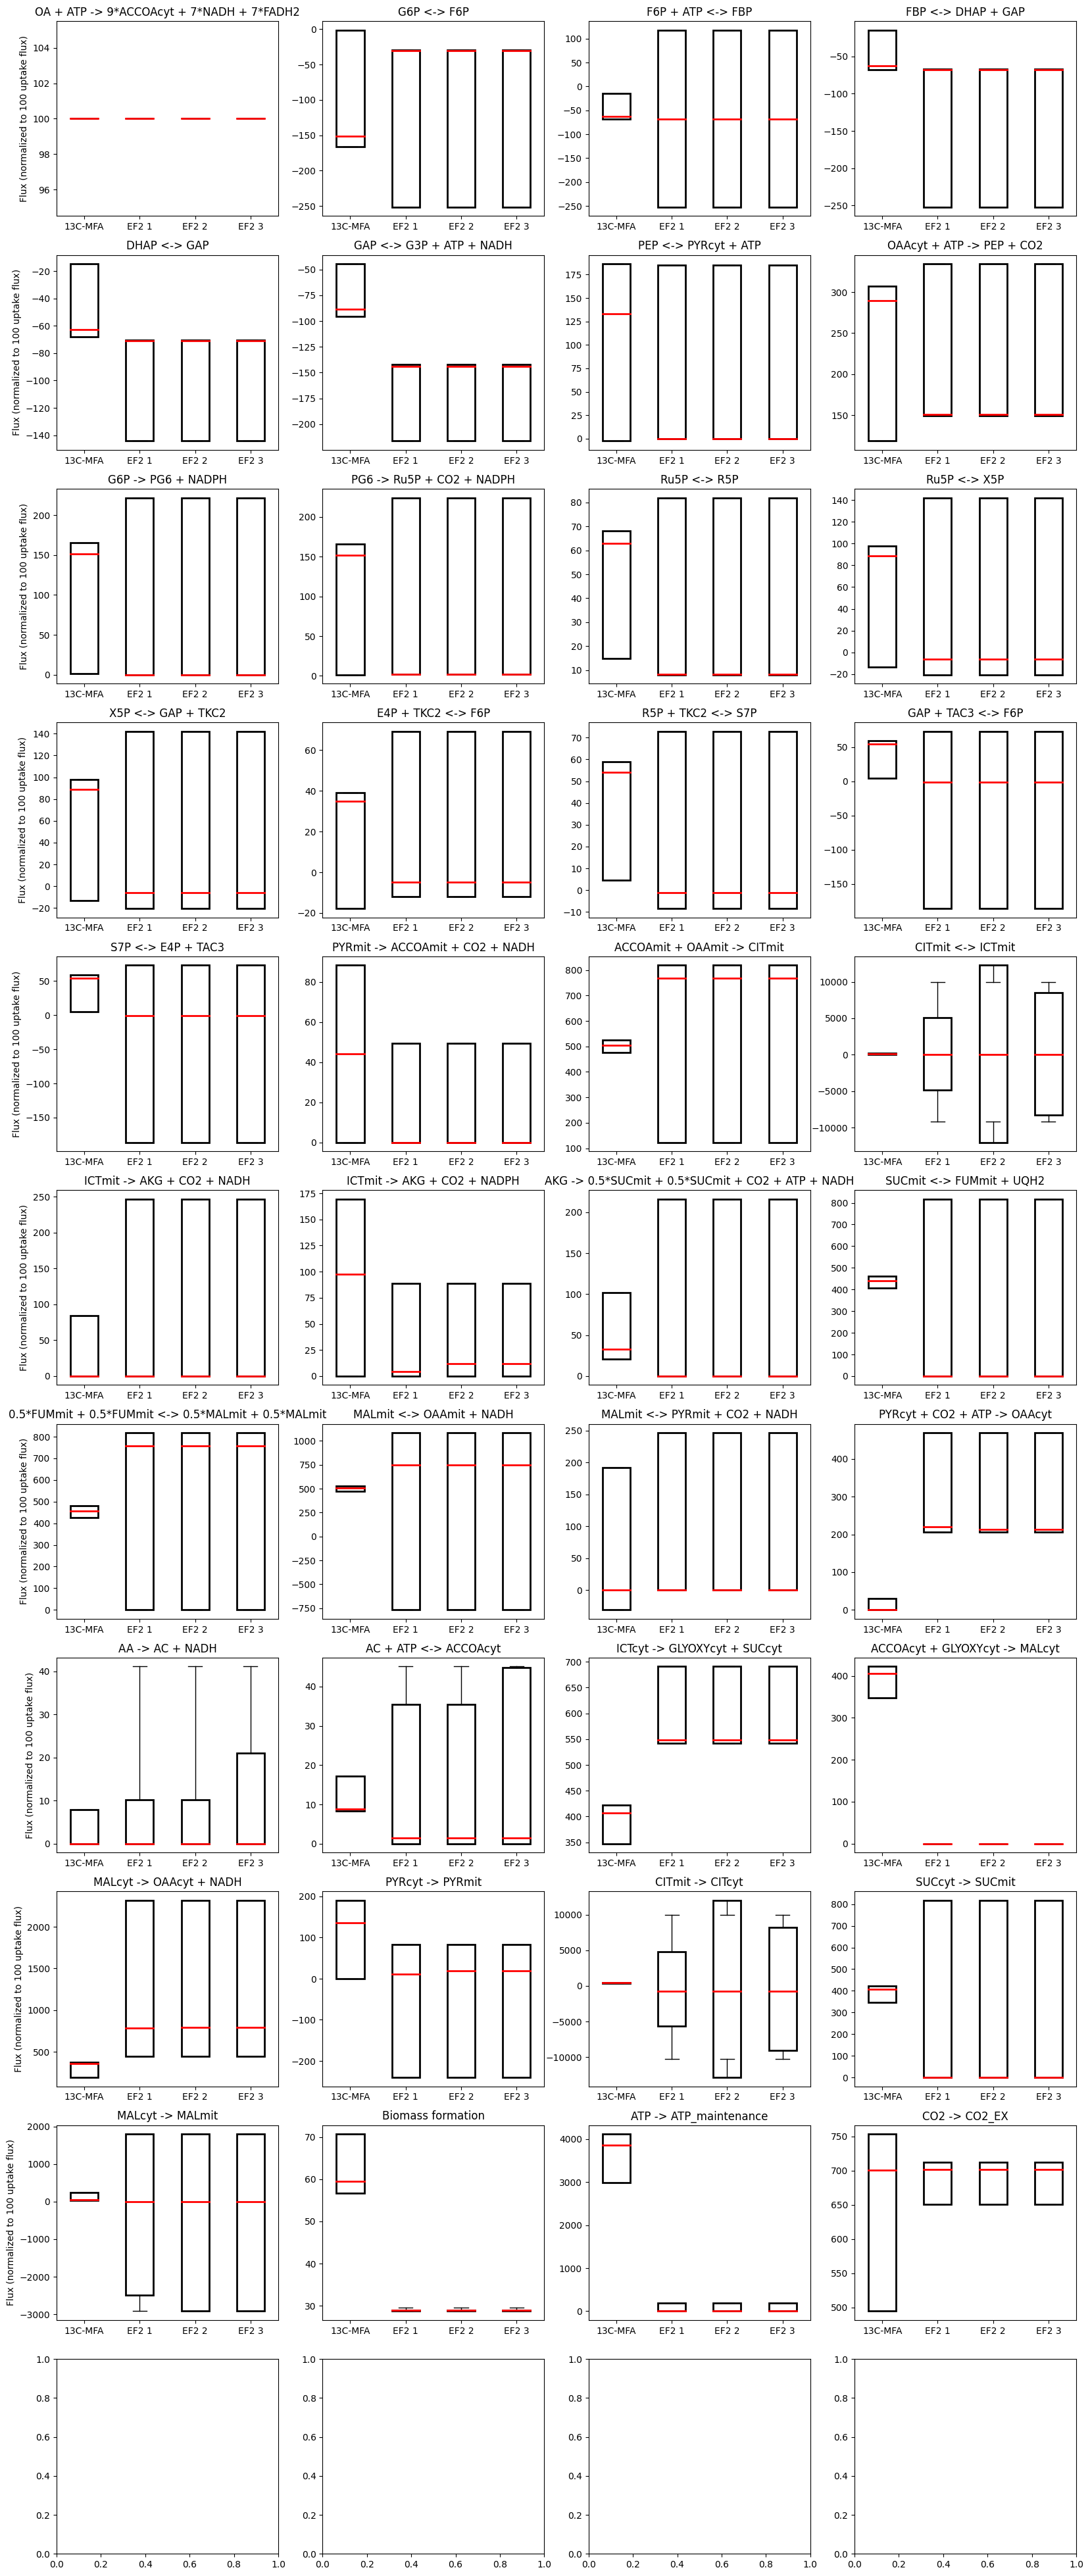

In [19]:
make_4_boxplot_grid(oleic_acid_central_rxn_df, 'oleic_acid')